In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [21]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from utils.dataset import NCDFDatasets
from utils.trainer import Trainer
from utils.trainer import Tester


Load specific variables for each dataset

In [3]:
version = 1
data_path = '../../../data/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset_type = 'chirps'
input_size = 50
step = 5
dropout_rate = 0.2
learning_rate = 0.001
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [4]:

#util = Util('STConvS2S', version=version, dataset_type=dataset_type)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [5]:
print(torch.version.cuda)

10.1


Seed

In [6]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [7]:
def init_seed(seed):
    np.random.seed(seed)

In [8]:
init_seed = init_seed(seed)

Hyperparameters

In [9]:
epochs = 50
batch_size = 25
validation_split = 0.2
test_split = 0.2
encoder_layer_size = param['encoder_layer_size']
decoder_layer_size = param['decoder_layer_size']
kernel_size = param['kernel_size']
filter_size = param['filter_size']

Loading the dataset

In [10]:
dataset = xr.open_dataset(data_path)
dataset

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...

In [11]:
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [12]:
print('[X_train] Shape:', train_data.x.shape)
print('[y_train] Shape:', train_data.y.shape)
print('[X_val] Shape:', val_data.x.shape)
print('[y_val] Shape:', val_data.y.shape)
print('[X_test] Shape:', test_data.x.shape)
print('[y_test] Shape:', test_data.y.shape)

[X_train] Shape: torch.Size([32429, 1, 5, 32, 32])
[y_train] Shape: torch.Size([32429, 1, 5, 32, 32])
[X_val] Shape: torch.Size([10809, 1, 5, 32, 32])
[y_val] Shape: torch.Size([10809, 1, 5, 32, 32])
[X_test] Shape: torch.Size([10809, 1, 5, 32, 32])
[y_test] Shape: torch.Size([10809, 1, 5, 32, 32])


In [13]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

Creating the model

In [14]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [15]:
class EncoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(EncoderSTCNN, self).__init__()
        self.padding = kernel_size // 2
        self.conv_layers = nn.ModuleList()
        self.mish_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        
        spatial_kernel_size =  [1, kernel_size, kernel_size]
        spatial_padding =  [0, self.padding, self.padding]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=spatial_kernel_size, padding=spatial_padding, bias=False)
            )
            self.mish_layers.append(Mish())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            in_channels = out_channels
        
    def forward(self, x):
        for conv, mish, batch in zip(self.conv_layers, self.mish_layers, 
                                           self.batch_layers):
            x = conv(x)
            x = batch(x)
            x = mish(x)
            
        return x

In [16]:
class DecoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(DecoderSTCNN, self).__init__()
        self.padding = kernel_size - 1
        self.conv_layers = nn.ModuleList()
        self.mish_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()

        temporal_kernel_size =  [kernel_size, 1, 1]
        temporal_padding =  [self.padding, 0, 0]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=temporal_kernel_size, padding=temporal_padding, bias=False)
            )
            self.mish_layers.append(Mish())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            in_channels = out_channels

        padding_final = [kernel_size // 2, 0, 0]
        self.conv_final = nn.Conv3d(in_channels=in_channels, out_channels=1, 
              kernel_size=temporal_kernel_size, padding=padding_final, bias=True)
        
    def forward(self, x):
        for conv, mish, batch in zip(self.conv_layers, self.mish_layers, 
                                           self.batch_layers):
            x = conv(x)[:,:,:-self.padding,:,:]
            x = batch(x)
            x = mish(x)
            
        out = self.conv_final(x)
        return out

In [17]:
class STConvS2S(nn.Module):
    
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels):
        super(STConvS2S, self).__init__()
        
        self.encoder = EncoderSTCNN(layer_size=encoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=channels)
        self.decoder = DecoderSTCNN(layer_size=decoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=filter_size)
        
    def forward(self, x):
        out = self.encoder(x)
        return self.decoder(out)

In [18]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [19]:
model = STConvS2S(encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels=train_data.x.shape[1]).to(device)
criterion = RMSELoss()
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)

Training the model

In [22]:
model_path = os.path.join('../../../models/CFSR/5_step/STConvS2S_Mish_Adamod' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, False, model_path, False, 5)


In [23]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 6.033364
Val Avg. Loss: 1.688203
=> Saving a new best
Train - Epoch 1, Epoch Loss: 1.657292
Val Avg. Loss: 1.781402
Train - Epoch 2, Epoch Loss: 1.621242
Val Avg. Loss: 1.667632
=> Saving a new best
Train - Epoch 3, Epoch Loss: 1.596845
Val Avg. Loss: 1.643935
=> Saving a new best
Train - Epoch 4, Epoch Loss: 1.575848
Val Avg. Loss: 1.655700
Train - Epoch 5, Epoch Loss: 1.563337
Val Avg. Loss: 1.542348
=> Saving a new best
Train - Epoch 6, Epoch Loss: 1.549457
Val Avg. Loss: 1.557984
Train - Epoch 7, Epoch Loss: 1.543693
Val Avg. Loss: 1.535509
=> Saving a new best
Train - Epoch 8, Epoch Loss: 1.534537
Val Avg. Loss: 1.530055
=> Saving a new best
Train - Epoch 9, Epoch Loss: 1.530628
Val Avg. Loss: 1.542338
Train - Epoch 10, Epoch Loss: 1.524930
Val Avg. Loss: 1.623462
Train - Epoch 11, Epoch Loss: 1.519485
Val Avg. Loss: 1.552703
Train - Epoch 12, Epoch Loss: 1.515567
Val Avg. Loss: 1.521432
=> Saving a new best
Train - Epoch 13, Epoch Loss: 1.513023
Val A

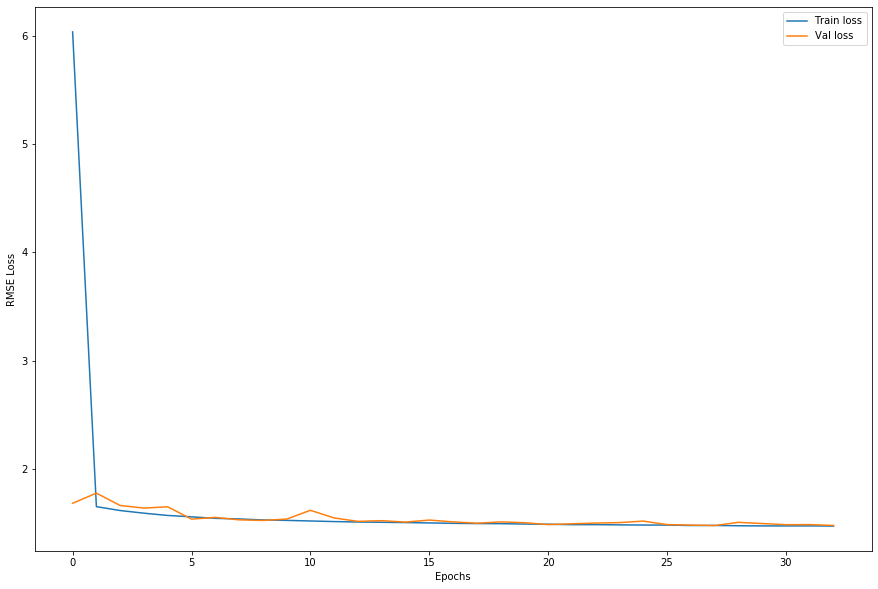

In [24]:
import matplotlib.pyplot as plt
epochs = np.arange(1,len(val_losses))
plt.figure(figsize=(15,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

Evaluating the model

In [25]:
model, optimizer, epoch, loss = trainer.load_model()
tester = Tester(model, test_loader, criterion, optimizer, device, False, False)
test_loss = tester.test()
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S RMSELoss: 1.4674


In [24]:
util.send_email(model_info)

2153.3084013462067
email sent
